# NFL One-Score Games: Data Exploration

This notebook explores NFL game results from the 2015–16 through 2023–24 seasons, 
focusing on how often games are decided by **one score (8 points or fewer)** 
versus larger blowouts.

The underlying dataset is the merged play-by-play data saved as `pbp_2015_2023.parquet`, 
created in the *establishing data* notebook.


In [ ]:
import polars as pl
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True


In [ ]:
plt.style.use("seaborn-v0_8-darkgrid")

FIELD_GREEN   = "#1B5E20"
GOLD          = "#F9A825"
DARK_BROWN    = "#4E342E"
LIGHT_TURF    = "#A5D6A7"
LINE_WHITE    = "#ECEFF1"

## 1. Load the game-level data

We start from the big play-by-play file and collapse it to one row per game 
with the final home and away scores.


In [ ]:

pbp = pl.read_parquet("pbp_2015_2023.parquet")
print("Raw play-by-play shape:", pbp.shape)

games = (
    pbp
    .group_by("game_id")
    .agg(
        home_team        = pl.col("home_team").first(),
        away_team        = pl.col("away_team").first(),
        home_score_final = pl.col("total_home_score").max(),
        away_score_final = pl.col("total_away_score").max(),
        season           = pl.col("season").max()
    )
)

games = games.filter((pl.col("season") >= 2015) & (pl.col("season") <= 2023))

print("Game-level shape:", games.shape)
games.head(10)


Raw play-by-play shape: (434113, 372)
Game-level shape: (2458, 6)


game_id,home_team,away_team,home_score_final,away_score_final,season
str,str,str,f64,f64,i32
"""2021_16_CHI_SEA""","""SEA""","""CHI""",24.0,25.0,2021
"""2016_16_SF_LA""","""LA""","""SF""",21.0,22.0,2016
"""2021_03_NO_NE""","""NE""","""NO""",13.0,28.0,2021
"""2020_08_ATL_CAR""","""CAR""","""ATL""",17.0,25.0,2020
"""2020_04_NE_KC""","""KC""","""NE""",26.0,10.0,2020
"""2023_08_MIN_GB""","""GB""","""MIN""",10.0,24.0,2023
"""2016_20_GB_ATL""","""ATL""","""GB""",44.0,21.0,2016
"""2017_16_BUF_NE""","""NE""","""BUF""",37.0,16.0,2017
"""2018_04_TB_CHI""","""CHI""","""TB""",48.0,10.0,2018


## 2. Define margin and one-score indicator

- `margin` = absolute difference between home and away final scores  
- `one_score` = `True` if `margin ≤ 8`, otherwise `False`


In [65]:
games = games.with_columns(
    margin = (pl.col("home_score_final") - pl.col("away_score_final")).abs()
)

games = games.with_columns(
    one_score = pl.col("margin") <= 8
)

games.select(["game_id", "season", "home_team", "away_team",
              "home_score_final", "away_score_final",
              "margin", "one_score"]).head(10)


game_id,season,home_team,away_team,home_score_final,away_score_final,margin,one_score
str,i32,str,str,f64,f64,f64,bool
"""2021_16_CHI_SEA""",2021,"""SEA""","""CHI""",24.0,25.0,1.0,true
"""2016_16_SF_LA""",2016,"""LA""","""SF""",21.0,22.0,1.0,true
"""2021_03_NO_NE""",2021,"""NE""","""NO""",13.0,28.0,15.0,false
"""2020_08_ATL_CAR""",2020,"""CAR""","""ATL""",17.0,25.0,8.0,true
"""2020_04_NE_KC""",2020,"""KC""","""NE""",26.0,10.0,16.0,false
"""2023_08_MIN_GB""",2023,"""GB""","""MIN""",10.0,24.0,14.0,false
"""2016_20_GB_ATL""",2016,"""ATL""","""GB""",44.0,21.0,23.0,false
"""2017_16_BUF_NE""",2017,"""NE""","""BUF""",37.0,16.0,21.0,false
"""2018_04_TB_CHI""",2018,"""CHI""","""TB""",48.0,10.0,38.0,false


## 3. Overall share of one-score games

Here we compute how many games in this period were decided by 8 points or fewer
versus by more than 8 points.


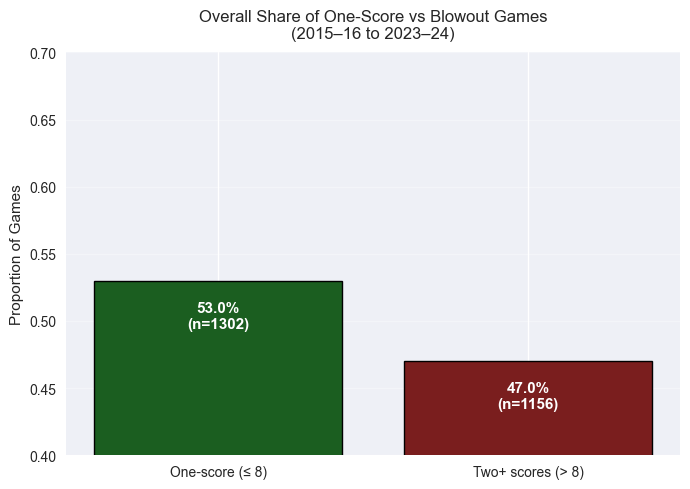

In [ ]:
labels = ["One-score (≤ 8)", "Two+ scores (> 8)"]
props  = [one_score_prop, blowout_prop]  

fig, ax = plt.subplots(figsize=(7, 5), facecolor="none")
ax.set_facecolor("#EEF0F6")

bars = ax.bar(
    labels,
    props,
    color=["#1B5E20", "#7A1E1E"],
    edgecolor="black",
    linewidth=1.0
)

ax.set_ylim(0.4, 0.7)
ax.set_ylabel("Proportion of Games")
ax.set_title("Overall Share of One-Score vs Blowout Games\n(2015–16 to 2023–24)", pad=10)
ax.grid(axis="y", alpha=0.35)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

counts = [one_score_count, blowout_count]
for bar, p, n in zip(bars, props, counts):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        p - 0.015,
        f"{p:.1%}\n(n={n})",
        ha="center",
        va="top",
        fontsize=11,
        color="white",
        fontweight="bold"
    )

plt.tight_layout()
plt.savefig("overall_one_score_vs_blowout_pretty_transparent.png", dpi=300, transparent=True)
plt.show()

In [ ]:

overall = overall.sort("one_score")

one_score_count = int(
    overall.filter(pl.col("one_score") == True)["n_games"][0]
)
blowout_count = int(
    overall.filter(pl.col("one_score") == False)["n_games"][0]
)
total_games = one_score_count + blowout_count

one_score_prop = one_score_count / total_games
blowout_prop   = blowout_count / total_games

print(f"Total games analysed: {total_games}")
print(f"One-score games (≤ 8): {one_score_count}  ({one_score_prop:.3%})")
print(f"Two+ score games (> 8): {blowout_count}  ({blowout_prop:.3%})")

Total games analysed: 2458
One-score games (≤ 8): 1302  (52.970%)
Two+ score games (> 8): 1156  (47.030%)


## 4. Share of one-score games by season

Next we look at how the fraction of one-score games changes from season to season.


In [44]:
season_summary = (
    games
    .group_by("season")
    .agg(
        n_games     = pl.len(),
        n_one_score = pl.when(pl.col("one_score")).then(1).otherwise(0).sum()
    )
    .with_columns(
        prop_one_score = pl.col("n_one_score") / pl.col("n_games")
    )
    .sort("season")
)

season_summary


season,n_games,n_one_score,prop_one_score
i32,u32,i32,f64
2015,267,147,0.550562
2016,267,149,0.558052
2017,267,129,0.483146
2018,267,143,0.535581
2019,267,139,0.520599
2020,269,141,0.524164
2021,285,136,0.477193
2022,284,164,0.577465
2023,285,154,0.540351


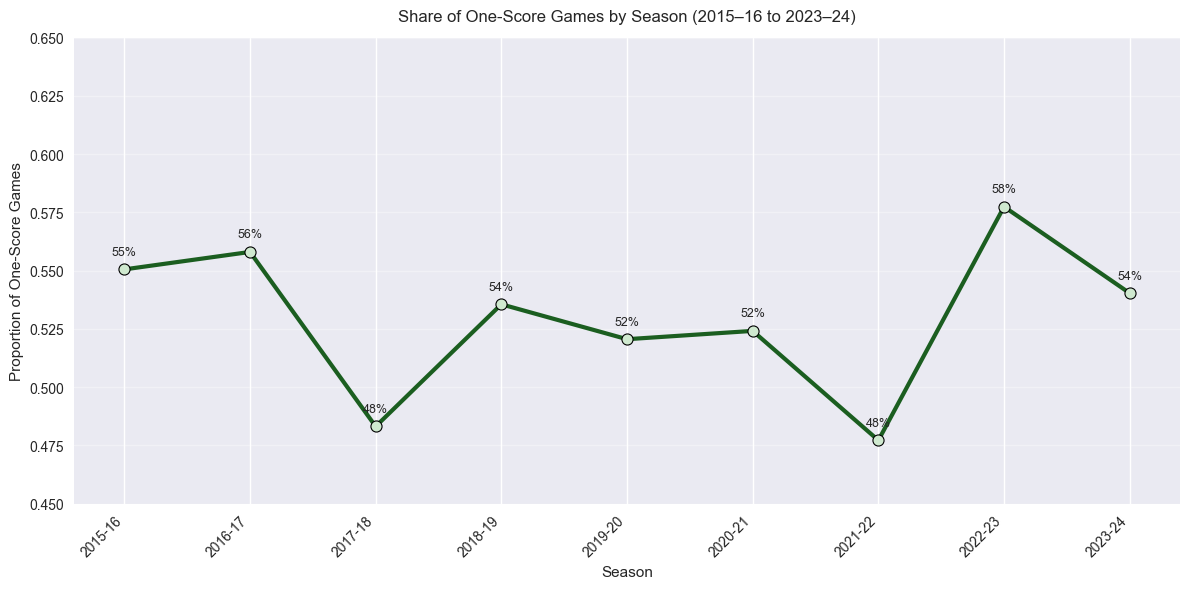

In [ ]:
import matplotlib.pyplot as plt
import polars as pl

season_summary = (
    games
    .group_by("season")
    .agg(
        n_games=pl.len(),
        n_one_score=pl.col("one_score").cast(pl.Int64).sum()
    )
    .with_columns(
        prop_one_score=(pl.col("n_one_score") / pl.col("n_games"))
    )
    .sort("season")
    .filter((pl.col("season") >= 2015) & (pl.col("season") <= 2023))
)

seasons = season_summary["season"].to_list()
props   = season_summary["prop_one_score"].to_list()

season_labels = [f"{s}-{str((s + 1) % 100).zfill(2)}" for s in seasons]

plt.style.use("seaborn-v0_8")  

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(
    season_labels,
    props,
    marker="o",
    linewidth=3,
    color="#1B5E20",          
    markerfacecolor="#CFE9CF",
    markeredgecolor="black",
    markeredgewidth=0.8,
    markersize=8
)

for x, y in zip(season_labels, props):
    ax.text(x, y + 0.005, f"{y:.0%}", ha="center", va="bottom", fontsize=9)

ax.set_ylim(0.45, 0.65)
ax.set_xlabel("Season")
ax.set_ylabel("Proportion of One-Score Games")
ax.set_title("Share of One-Score Games by Season (2015–16 to 2023–24)", pad=12)
ax.grid(axis="y", alpha=0.35)

plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.savefig("one_score_by_season_pretty_transparent.png", dpi=300, transparent=True)
plt.show()

## 5. Distribution of final score margins

Here we look at how common different final point differentials are.
First with a histogram, then with exact counts for margins from 1 to 28 points.


In [54]:
margin_counts = (
    games
    .group_by("margin")
    .agg(n_games = pl.len())
    .sort("margin")
)
margin_counts = margin_counts.filter(
    (pl.col("margin") >= 1) & (pl.col("margin") <= 28)
)

margin_counts.head()

margin,n_games
f64,u32
1.0,108
2.0,108
3.0,364
4.0,113
5.0,104


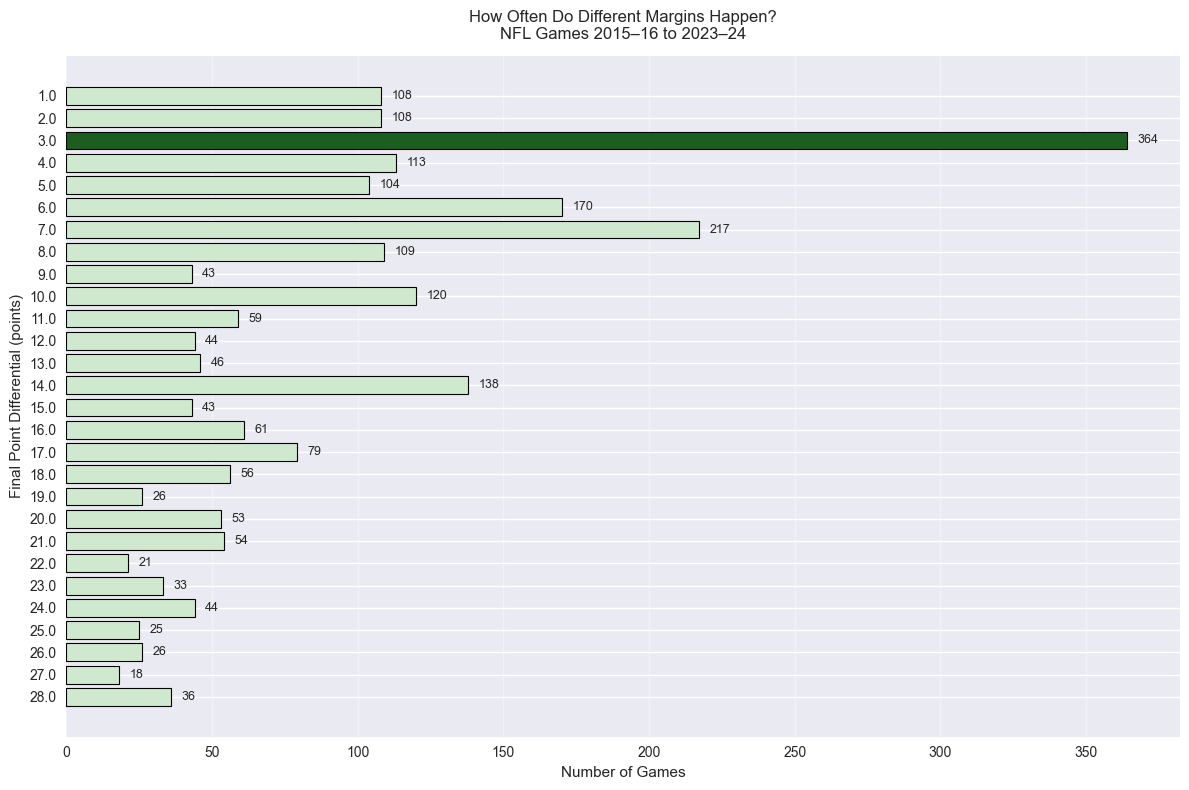

<Figure size 800x550 with 0 Axes>

In [ ]:
import numpy as np
margin_counts = (
    games
    .group_by("margin")
    .agg(n_games=pl.len())
    .sort("margin")
    .filter((pl.col("margin") >= 1) & (pl.col("margin") <= 28))
)

margins = margin_counts["margin"].to_list()
counts  = margin_counts["n_games"].to_list()

plt.style.use("seaborn-v0_8")  

highlight_margin = margins[int(np.argmax(counts))]  

colors = []
for m, c in zip(margins, counts):
    if m == highlight_margin:
        colors.append("#1B5E20")  
    else:
        colors.append("#CFE9CF")  

fig, ax = plt.subplots(figsize=(12, 8))

ax.barh([str(m) for m in margins], counts, color=colors, edgecolor="black", linewidth=0.8)

ax.set_title("How Often Do Different Margins Happen?\nNFL Games 2015–16 to 2023–24", pad=12)
ax.set_xlabel("Number of Games")
ax.set_ylabel("Final Point Differential (points)")
ax.invert_yaxis()

offset = max(counts) * 0.01
for i, c in enumerate(counts):
    ax.text(c + offset, i, str(c), va="center", fontsize=9)

ax.grid(axis="x", alpha=0.35)
plt.tight_layout()
plt.savefig("margin_bar_horizontal_pretty.png", dpi=300)
plt.show()

plt.savefig("margin_bar_horizontal_pretty_transparent.png", dpi=300, transparent=True)

## 6. Takeaways from exploration

From this initial exploration, we now know:

- How many games are in our sample and which seasons they cover  
- What fraction of games are decided by one score overall  
- How the one-score share varies by season  
- How common different final margins (1–28 points) are

These results give us a solid baseline for designing the final infographic and 
for any deeper questions we want to pursue (for example, whether certain teams 
or years are especially close).
